<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/Hareketli_Ortalama_Taramas%C4%B1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-6w0ggfgo
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-6w0ggfgo
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done


Hangi hareketli ortalama türünü kullanmak istersiniz? (EMA/SMA): ema
Lütfen taramak istediğiniz EMA/SMA periyotlarını virgülle ayırarak yazınız (Örn: 21,34,55,89): 89
Hangi zaman aralığını seçmek istersiniz? (Aylık, Haftalık, Günlük, 4 saatlik): haftalık


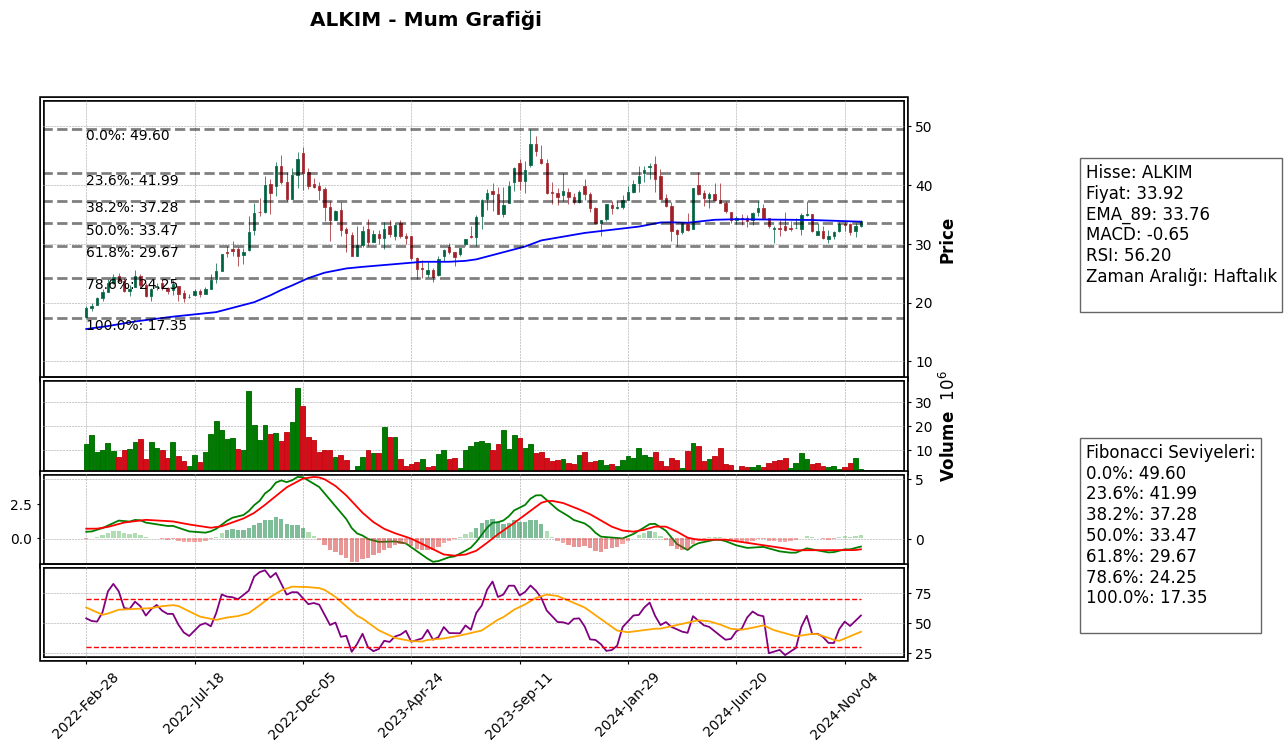

ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


BRLSM işlenirken hata: 'NoneType' object is not subscriptable


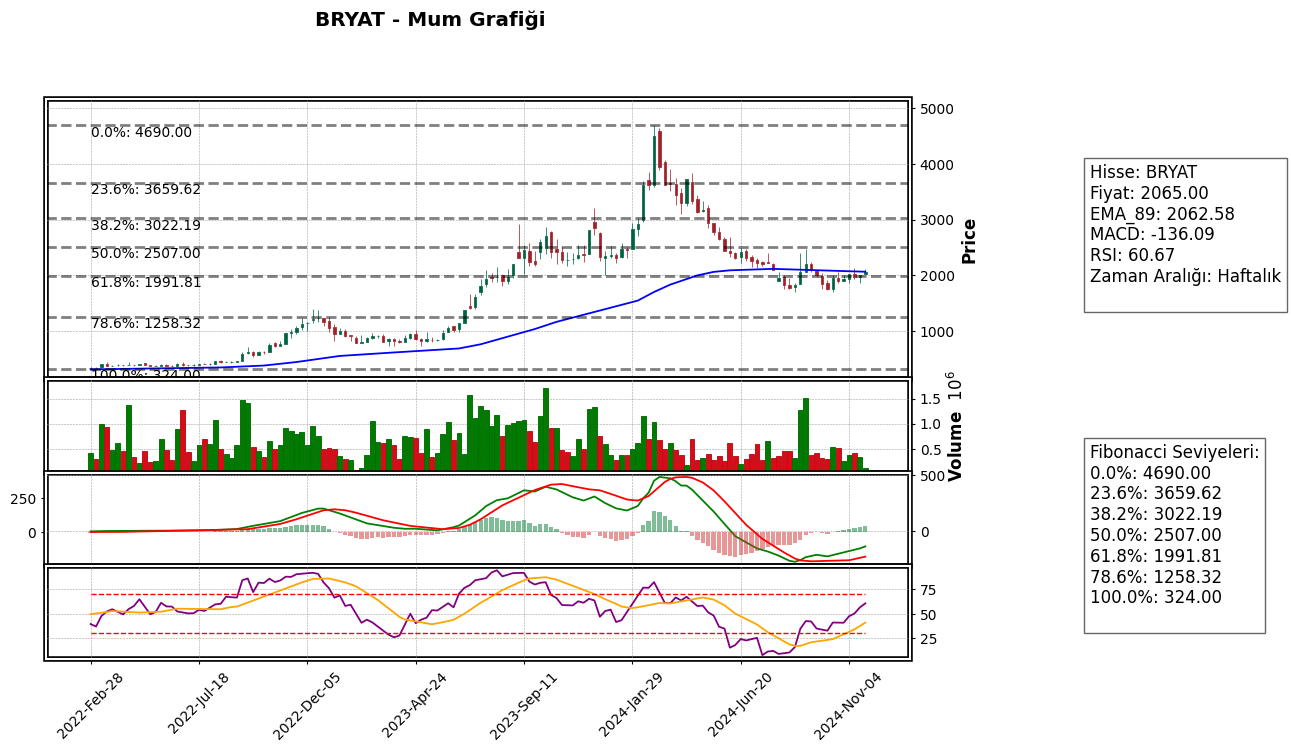

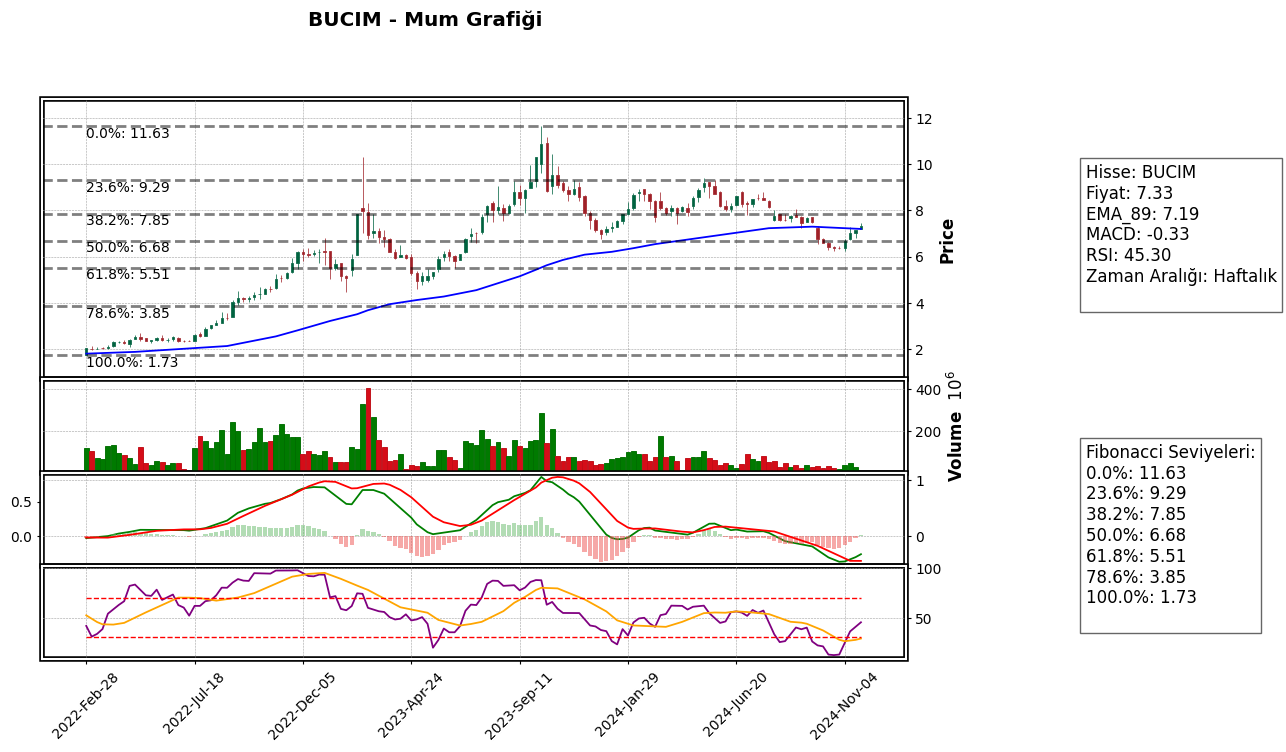

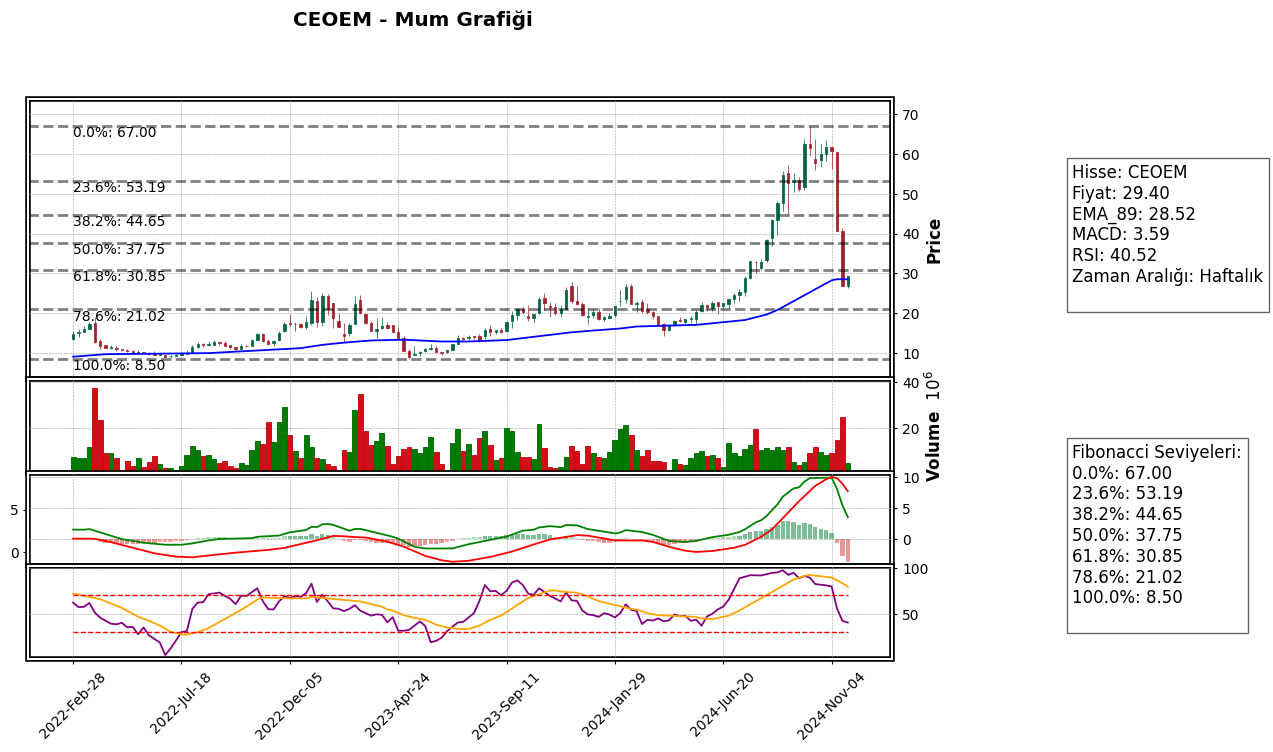

ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


GENTS işlenirken hata: 'NoneType' object is not subscriptable


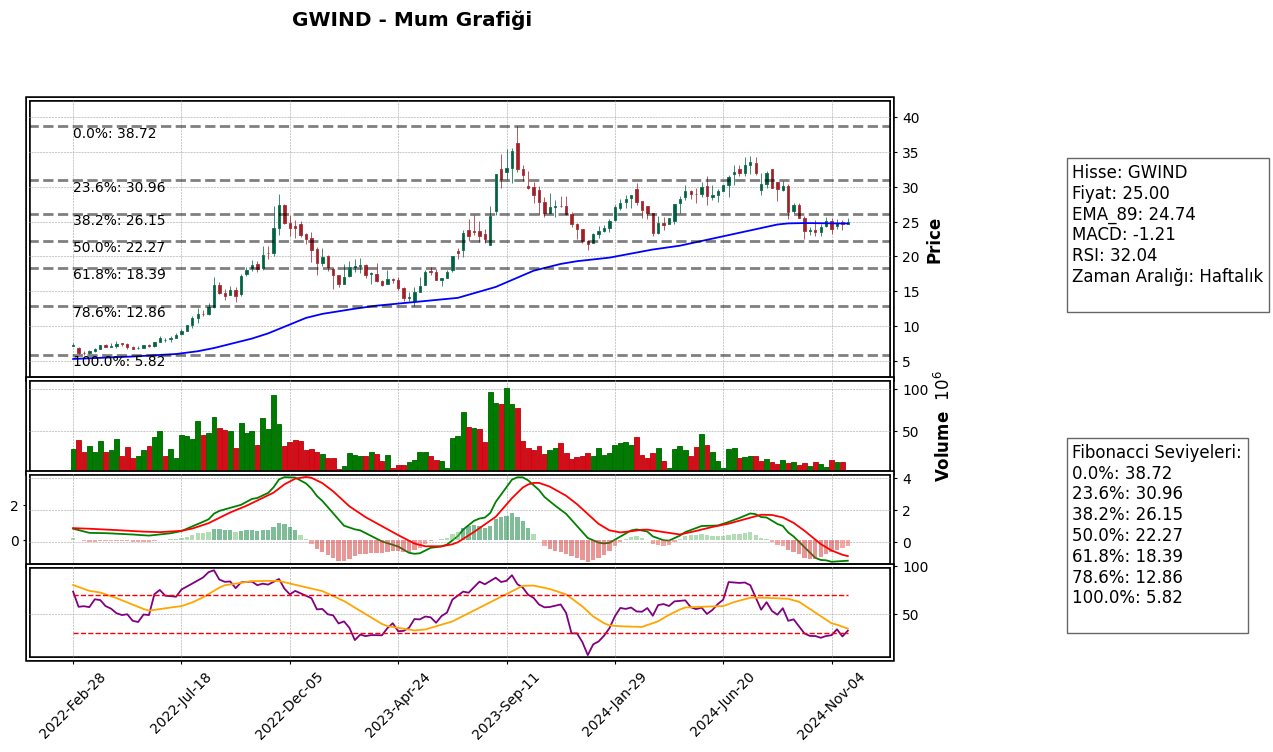

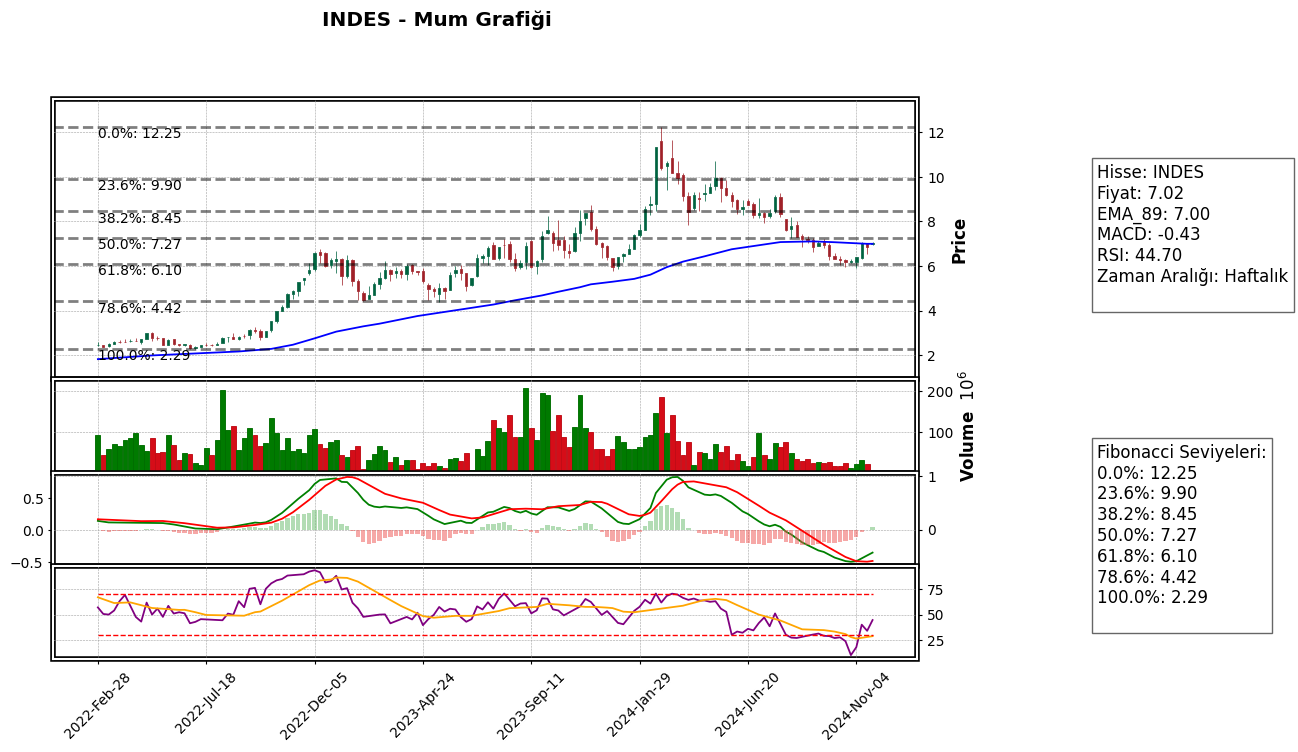

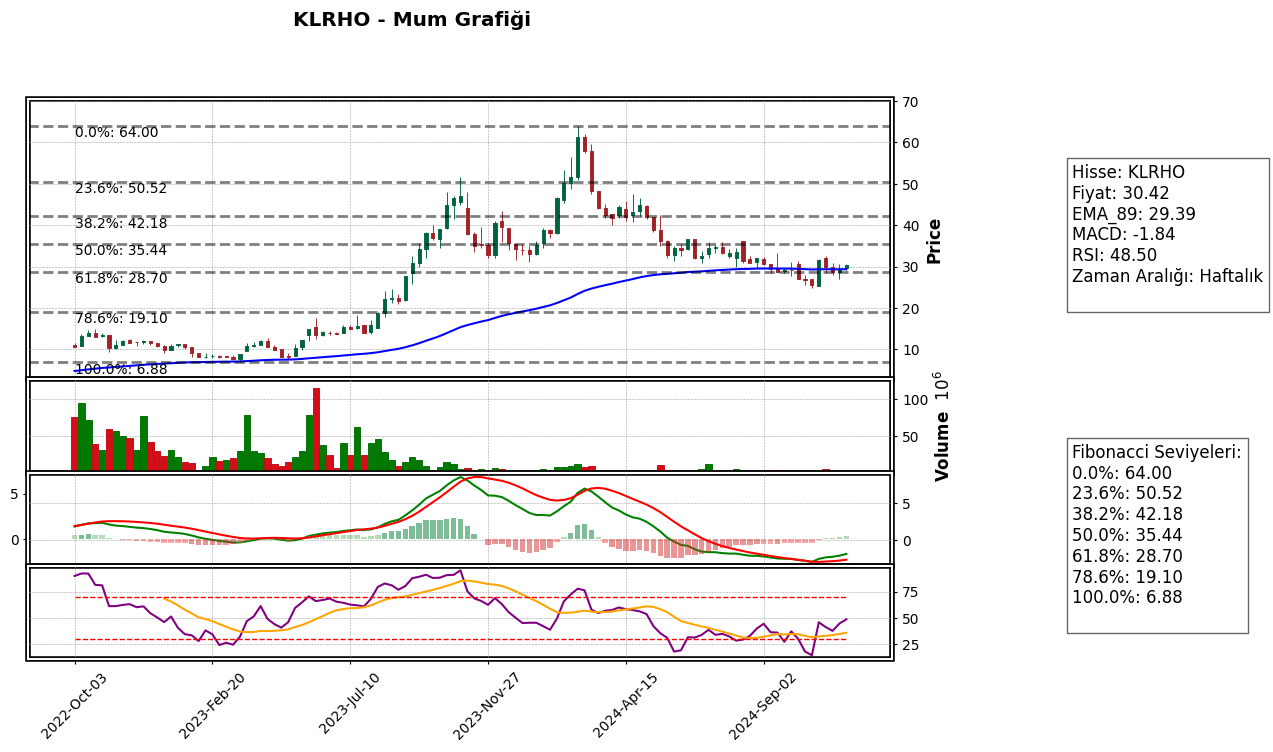

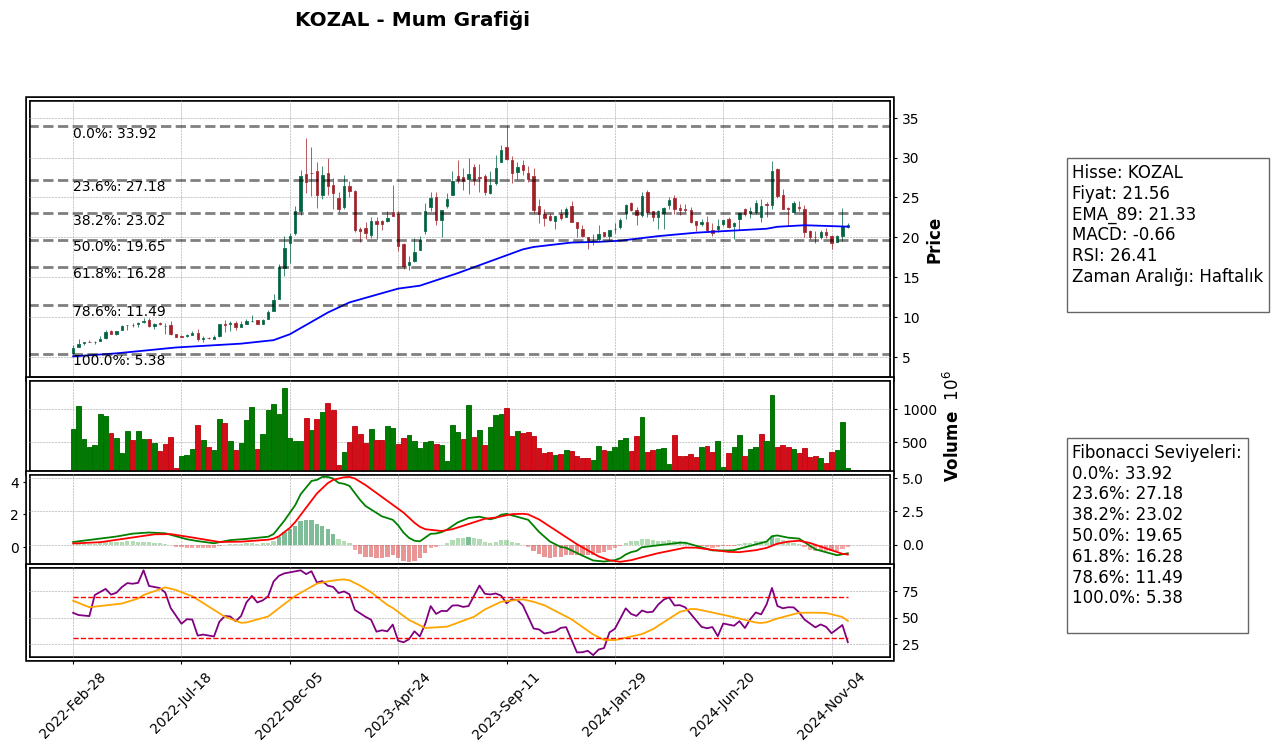

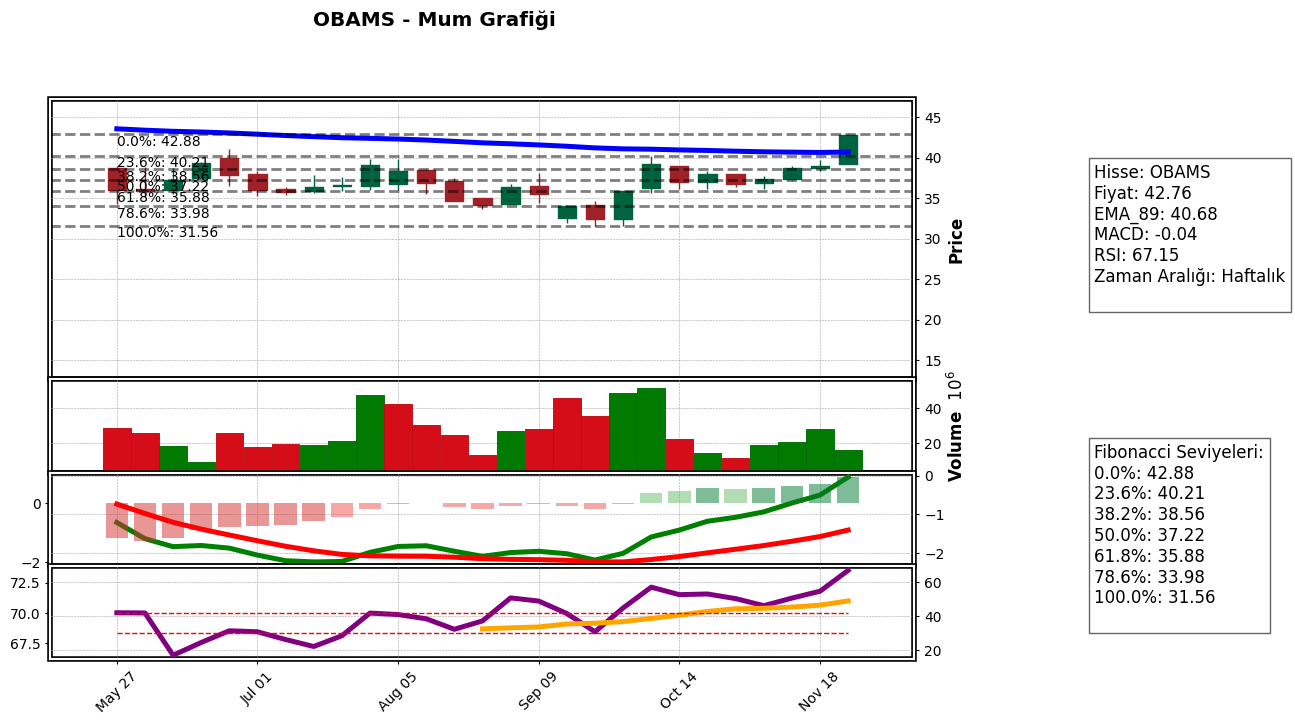

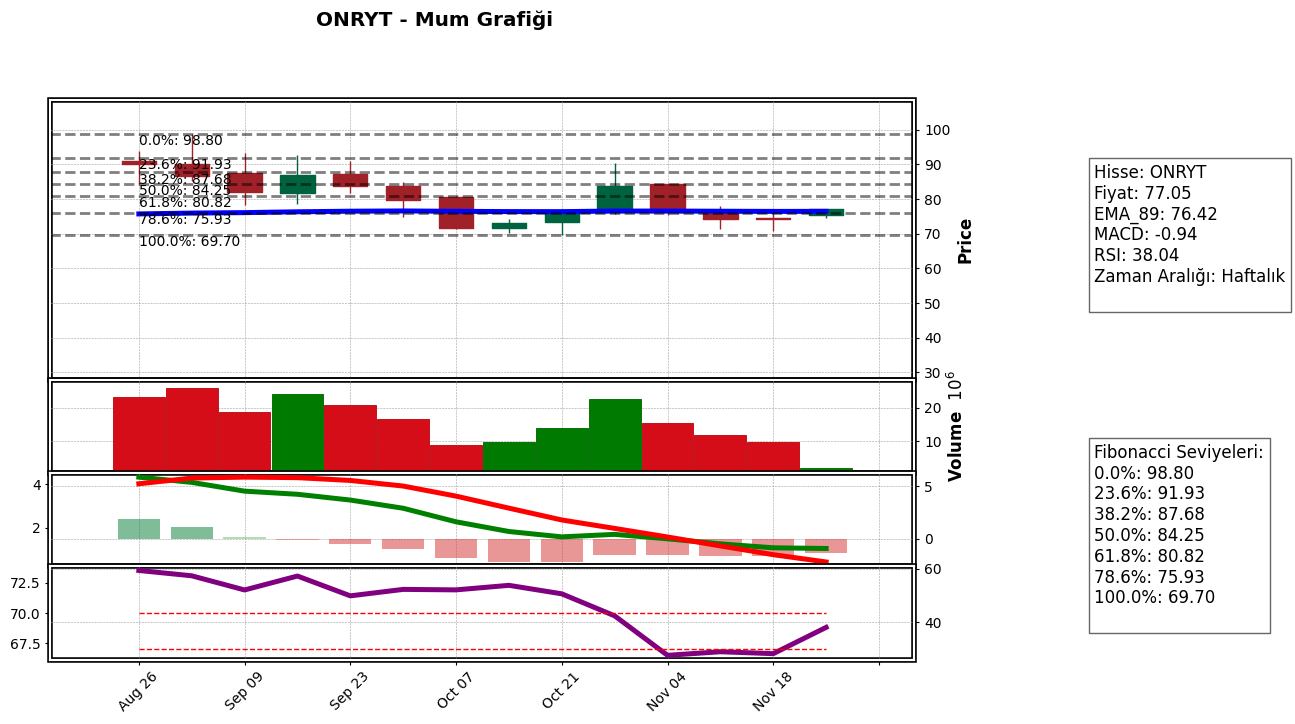

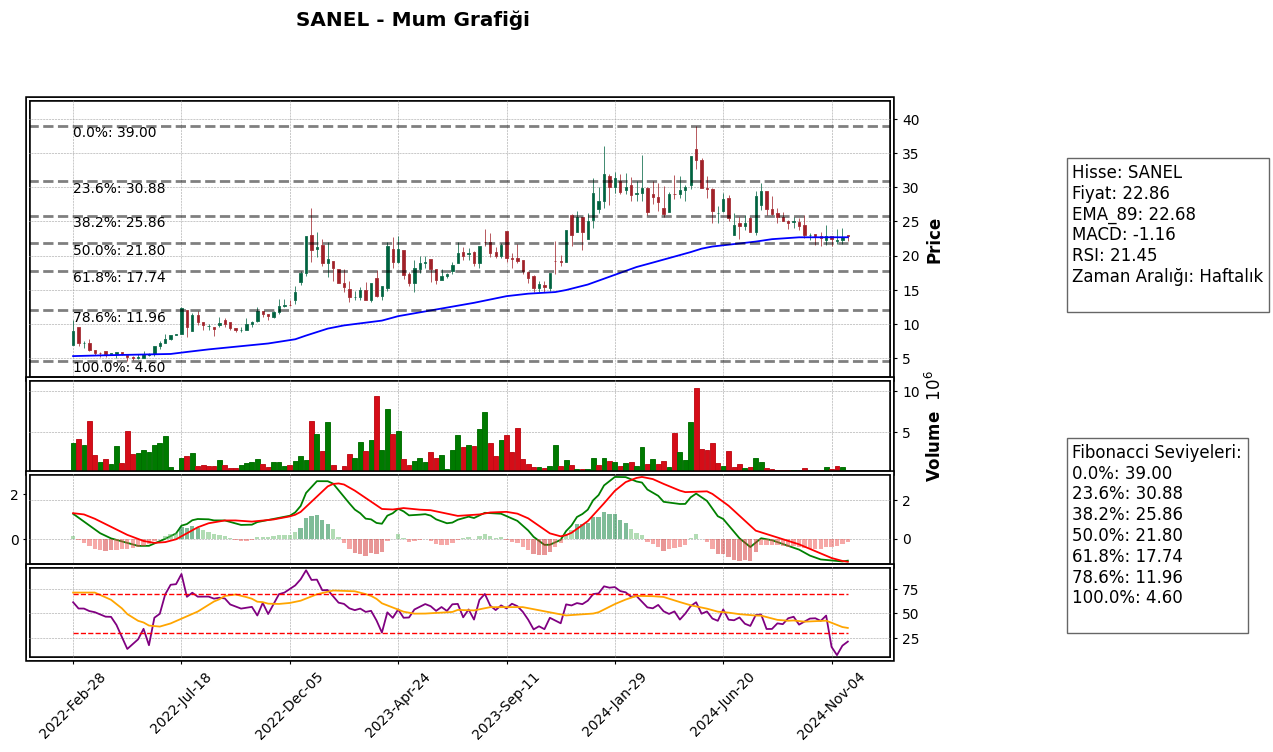

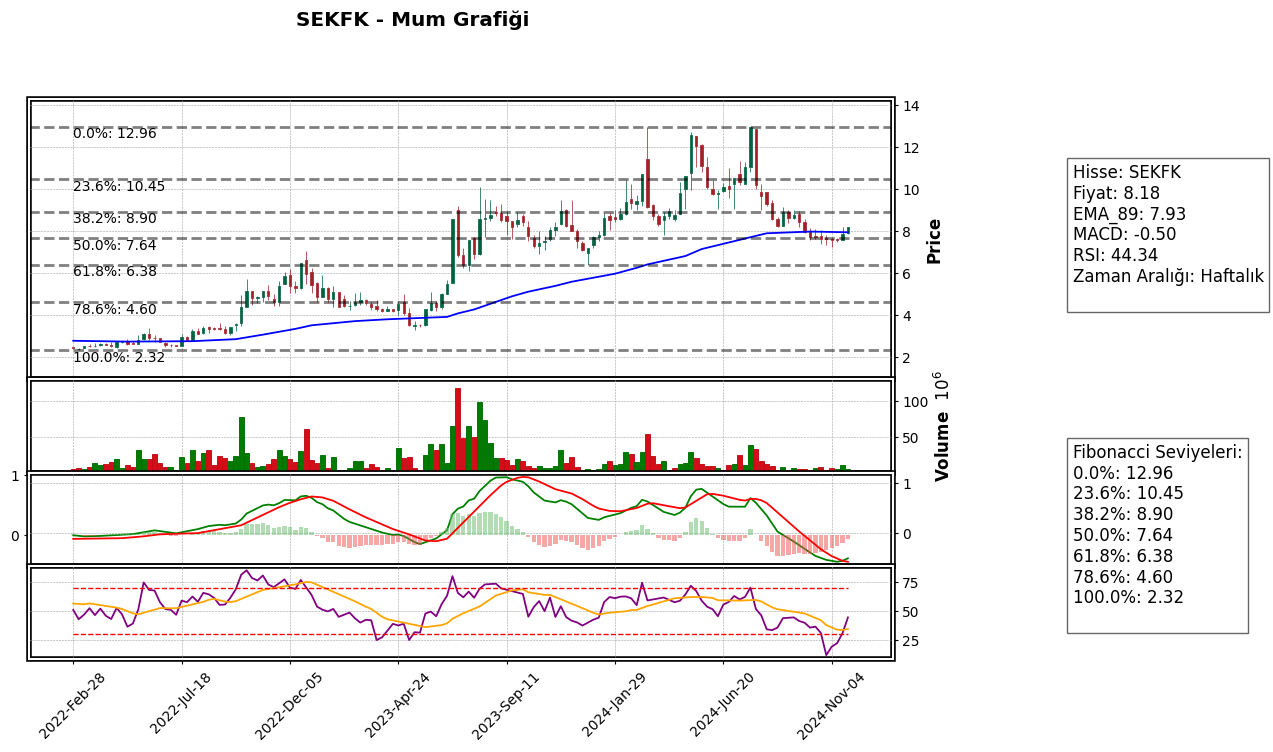

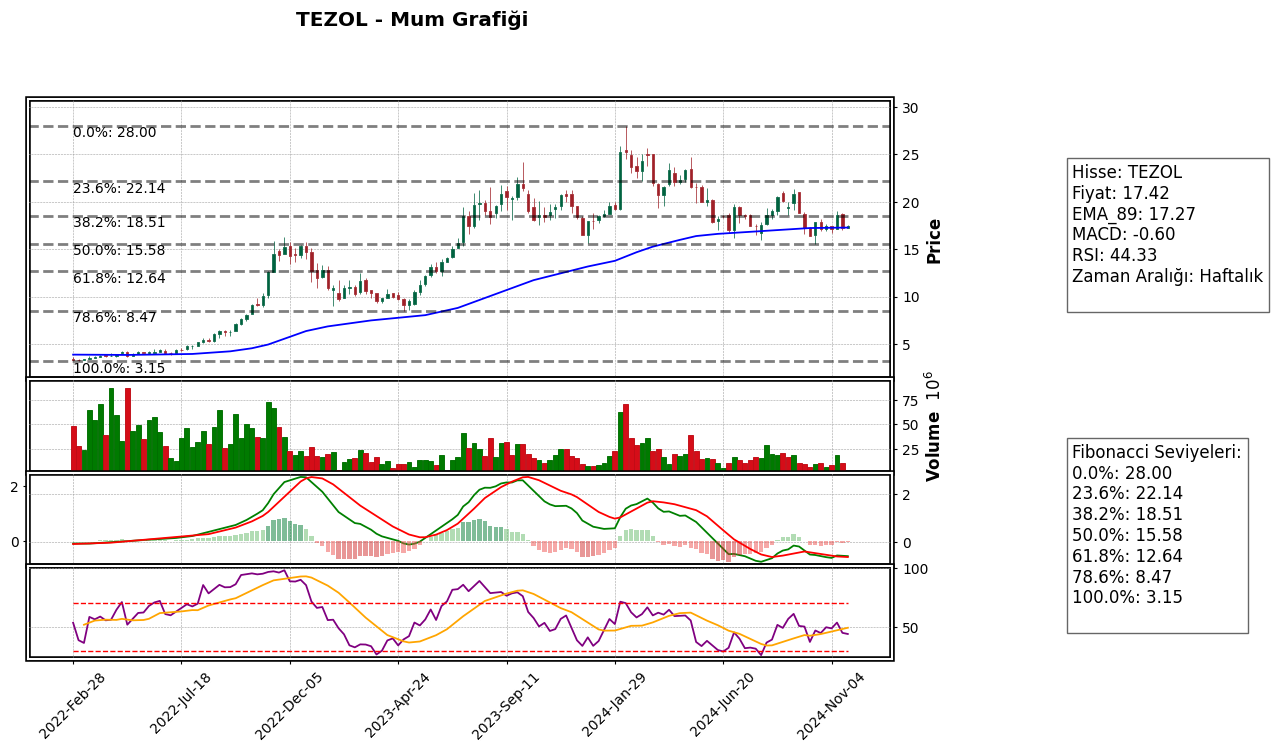

ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol


TTRAK işlenirken hata: 'NoneType' object is not subscriptable


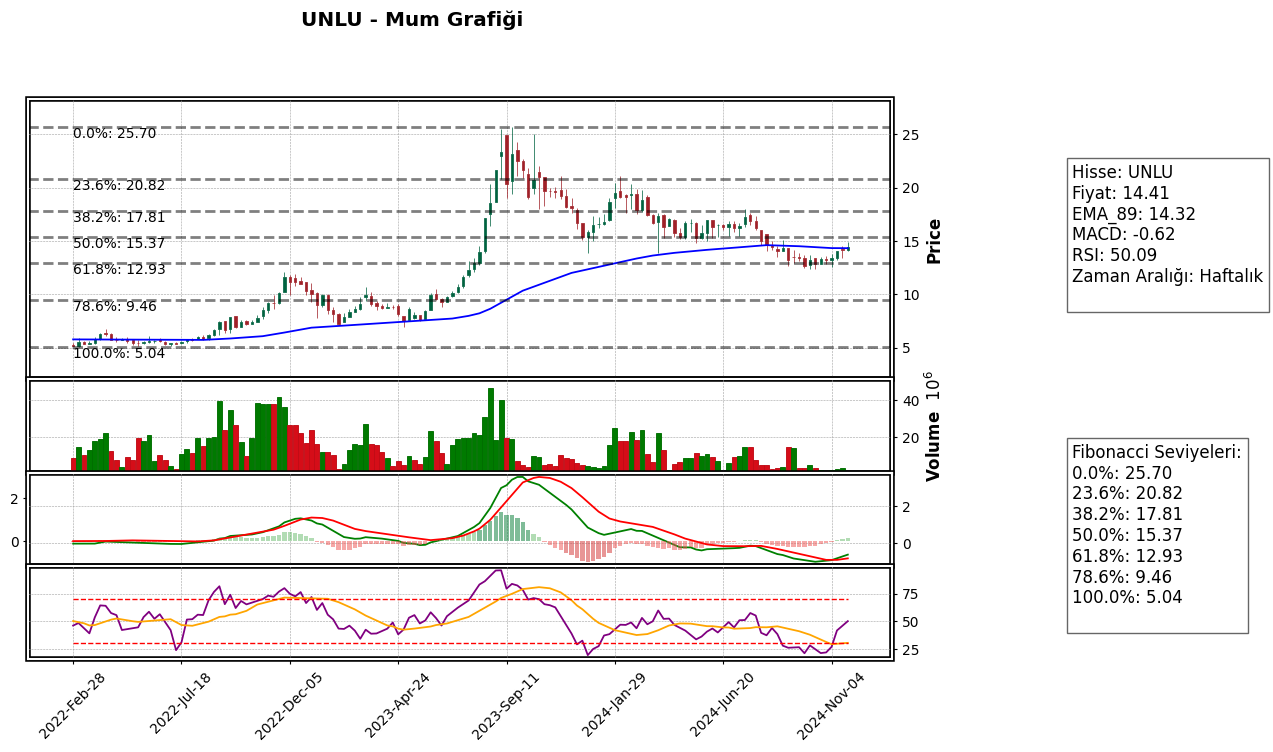

In [ ]:

!pip install git+https://github.com/rongardF/tvdatafeed
!pip install tradingview-screener
!pip install backtesting
!pip install tabulate
!pip install mplfinance

import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import warnings
import matplotlib.pyplot as plt
import mplfinance as mpf
from tabulate import tabulate

warnings.simplefilter(action='ignore')

tv = TvDatafeed()

symbols = get_all_symbols(market='turkey')
symbols = [symbol.replace('BIST:', '') for symbol in symbols]
symbols = sorted(symbols)

valid_ma_types = ['ema', 'sma']
while True:
    ma_type_input = input("Hangi hareketli ortalama türünü kullanmak istersiniz? (EMA/SMA): ").lower()
    if ma_type_input in valid_ma_types:
        break
    else:
        print("Geçersiz hareketli ortalama türü seçimi. Lütfen 'EMA' veya 'SMA' girin.")

def calculate_ema(data, period):
    return data['close'].ewm(span=period, adjust=False).mean()

def calculate_sma(data, period):
    return data['close'].rolling(window=period).mean()

def calculate_macd(data, slow=26, fast=12, signal=9):
    macd_line = data['close'].ewm(span=fast, adjust=False).mean() - data['close'].ewm(span=slow, adjust=False).mean()
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def calculate_rsi(data, period=14):
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

while True:
    ma_input = input("Lütfen taramak istediğiniz EMA/SMA periyotlarını virgülle ayırarak yazınız (Örn: 21,34,55,89): ")
    try:
        ma_periods = [int(period.strip()) for period in ma_input.split(',')]
        break
    except ValueError:
        print("Geçersiz giriş. Lütfen sadece sayı girin.")

valid_intervals = ['aylık', 'haftalık', 'günlük', '4 saatlik']
while True:
    interval_input = input("Hangi zaman aralığını seçmek istersiniz? (Aylık, Haftalık, Günlük, 4 saatlik): ").lower()
    if interval_input in valid_intervals:
        break
    else:
        print("Geçersiz zaman aralığı seçimi. Lütfen geçerli bir zaman aralığı girin.")

if interval_input == 'aylık':
    selected_interval = Interval.in_monthly
elif interval_input == 'haftalık':
    selected_interval = Interval.in_weekly
elif interval_input == 'günlük':
    selected_interval = Interval.in_daily
elif interval_input == '4 saatlik':
    selected_interval = Interval.in_4_hour
else:
    raise ValueError("Geçersiz zaman aralığı seçimi.")

results = []

def add_table_to_plot(fig, stock_data, fib_levels):
    text = ""
    text += f"Hisse: {stock_data['Hisse']}\n"
    text += f"Fiyat: {stock_data['Fiyat']}\n"
    text += f"{stock_data['Periyot']}: {stock_data[stock_data['Periyot']]}\n"
    text += f"MACD: {stock_data['MACD']}\n"
    text += f"RSI: {stock_data['RSI']}\n"
    text += f"Zaman Aralığı: {stock_data['Zaman Aralığı']}\n"
    if 'Fibonacci Kesişim' in stock_data:
        fig.text(1.05, 0.55, f"Fibonacci Kesişim: {stock_data['Fibonacci Kesişim']}", fontsize=12, va='center', ha='left', transform=fig.transFigure, color='red', bbox=dict(facecolor='white', alpha=0.6))

    fib_table = "Fibonacci Seviyeleri:\n"
    for label, level in fib_levels.items():
        fib_table += f"{label}: {level:.2f}\n"

    fig.text(1.05, 0.80, text, fontsize=12, va='top', ha='left', transform=fig.transFigure, bbox=dict(facecolor='white', alpha=0.6))
    fig.text(1.05, 0.45, fib_table, fontsize=12, va='top', ha='left', transform=fig.transFigure, bbox=dict(facecolor='white', alpha=0.6))

def calculate_and_plot_fibonacci(ax, df, lookback=144, close_price=None, ma_value=None):

    max_price = df['high'].tail(lookback).max()
    min_price = df['low'].tail(lookback).min()


    diff = max_price - min_price
    levels = {
        '0.0%': max_price,
        '23.6%': max_price - 0.236 * diff,
        '38.2%': max_price - 0.382 * diff,
        '50.0%': max_price - 0.5 * diff,
        '61.8%': max_price - 0.618 * diff,
        '78.6%': max_price - 0.786 * diff,
        '100.0%': min_price
    }

    overlap_fib_level = None


    for label, level in levels.items():
        line_color = 'black'
        if close_price is not None and ma_value is not None:

            if abs(close_price - level) <= (close_price * 0.01) and abs(ma_value - level) <= (ma_value * 0.01):
                line_color = 'red'
                overlap_fib_level = label

        ax.axhline(level, linestyle='--', alpha=0.5, color=line_color)
        ax.text(0.01, level, f"{label}: {level:.2f}", verticalalignment='top', fontsize=10, color=line_color)


    ax.set_ylim([min_price * 0.40, max_price * 1.10])

    return overlap_fib_level, levels


for symbol in symbols:
    try:

        df = tv.get_hist(symbol=symbol, exchange='BIST', interval=selected_interval, n_bars=2000)


        for period in ma_periods:
            if ma_type_input == 'ema':
                ma_column = f'EMA_{period}'
                df[ma_column] = calculate_ema(df, period)
            else:
                ma_column = f'SMA_{period}'
                df[ma_column] = calculate_sma(df, period)


        df['MACD_line'], df['Signal_line'], df['MACD_hist'] = calculate_macd(df)
        df['RSI'] = calculate_rsi(df)


        df['RSI_SMA'] = df['RSI'].rolling(window=14).mean()


        close_price = df['close'].iloc[-1]
        close_price2 = df['close'].iloc[-2]


        for period in ma_periods:
            ma_column = f'{ma_type_input.upper()}_{period}'


            if ma_column not in df.columns:
                print(f"{symbol} için {ma_column} hesaplanamadı, devam ediliyor.")
                continue

            ma_value = df[ma_column].iloc[-1]


            if close_price == ma_value or df['low'].iloc[-1] <= ma_value <= df['high'].iloc[-1] and close_price >= ma_value and close_price >= close_price2:

                stock_data = {
                    'Hisse': symbol,
                    'Fiyat': f"{close_price:.2f}",
                    f'{ma_column}': f"{ma_value:.2f}",
                    'Zaman Aralığı': interval_input.capitalize(),
                    'Periyot': f"{ma_column}",
                    'MACD': f"{df['MACD_line'].iloc[-1]:.2f}",
                    'RSI': f"{df['RSI'].iloc[-1]:.2f}"
                }


                valid_data = df.dropna(subset=[ma_column, 'MACD_line', 'RSI']).tail(144)


                ap_ma = mpf.make_addplot(valid_data[ma_column], color='blue')
                ap_macd_lines = [
                    mpf.make_addplot(valid_data['MACD_line'], panel=2, color='green'),
                    mpf.make_addplot(valid_data['Signal_line'], panel=2, color='red'),
                ]

                hist_colors = []
                for x in valid_data['MACD_hist']:
                    if x > 0.5:
                        hist_colors.append('#007A33')
                    elif x > 0:
                        hist_colors.append('#66BB6A')
                    elif x < -0.5:
                        hist_colors.append('#D32F2F')
                    else:
                        hist_colors.append('#EF5350')

                ap_macd_hist = mpf.make_addplot(valid_data['MACD_hist'], type='bar', panel=2, color=hist_colors, alpha=0.5)

                ap_rsi = [
                    mpf.make_addplot(valid_data['RSI'], panel=3, color='purple'),
                    mpf.make_addplot(valid_data['RSI_SMA'], panel=3, color='orange')
                ]


                ap_rsi.append(mpf.make_addplot([30] * len(valid_data), panel=3, color='red', linestyle='--', width=1))
                ap_rsi.append(mpf.make_addplot([70] * len(valid_data), panel=3, color='red', linestyle='--', width=1))

                fig, axlist = mpf.plot(valid_data, type='candle', style='charles', title=f'{symbol} - Mum Grafiği',
                                       volume=True, figsize=(12, 8), addplot=[ap_ma] + ap_macd_lines + [ap_macd_hist] + ap_rsi, returnfig=True, panel_ratios=(18, 6, 6, 6))

                for ax in axlist:
                    ax.patch.set_edgecolor('black')
                    ax.patch.set_linewidth(4)


                overlap_fib_level, fib_levels = calculate_and_plot_fibonacci(axlist[0], valid_data, close_price=close_price, ma_value=ma_value)


                for label, level in fib_levels.items():
                    if overlap_fib_level == label:
                        stock_data['Fibonacci Kesişim'] = f"{label}: {level:.2f}"
                    else:
                        stock_data[label] = f"{level:.2f}"


                add_table_to_plot(fig, stock_data, fib_levels)

                plt.show()

    except Exception as e:
        print(f"{symbol} işlenirken hata: {e}")
